# Preparation

In [ ]:
%%capture
!pip install bayesian-optimization
!pip install git+https://github.com/aleju/imgaug.git


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from torch.utils.data import RandomSampler, DataLoader, SequentialSampler, TensorDataset
from tqdm.auto import tqdm
import logging
from os import listdir
from os.path import splitext
from pathlib import Path
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
from torch import Tensor
from torchvision import transforms
from bayes_opt import BayesianOptimization
from PIL import Image

# Dataset

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir: str, masks_dir: str, scale: float = 1.0, mask_suffix: str = '', transform = None):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
        self.scale = scale
        self.mask_suffix = mask_suffix
        self.transform = transform

        self.ids = [splitext(file)[0] for file in listdir(images_dir) if not file.startswith('.')]
        if not self.ids:
            raise RuntimeError(f'No input file found in {images_dir}, make sure you put your images there')
        logging.info(f'Creating dataset with {len(self.ids)} examples')

    def __len__(self):
        return len(self.ids)

    @classmethod
    def preprocess(cls, pil_img, scale, is_mask):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small, resized images would have no pixel'
        pil_img = pil_img.resize((newW, newH))
        img_ndarray = np.asarray(pil_img)

        if img_ndarray.ndim == 2 and not is_mask:
            img_ndarray = img_ndarray[np.newaxis, ...]
        elif not is_mask:
            img_ndarray = img_ndarray.transpose((2, 0, 1))

        if not is_mask:
            img_ndarray = img_ndarray / 255
            
        if is_mask:
            img_ndarray = img_ndarray / 255

        return img_ndarray

    @classmethod
    def load(cls, filename):
        ext = splitext(filename)[1]
        if ext in ['.npz', '.npy']:
            return Image.fromarray(np.load(filename))
        elif ext in ['.pt', '.pth']:
            return Image.fromarray(torch.load(filename).numpy())
        else:
            return Image.open(filename)

    def __getitem__(self, idx):
        name = self.ids[idx]
        mask_file = list(self.masks_dir.glob(name + self.mask_suffix + '.*'))
        img_file = list(self.images_dir.glob(name + '.*'))

        assert len(mask_file) == 1, f'Either no mask or multiple masks found for the ID {name}: {mask_file}'
        assert len(img_file) == 1, f'Either no image or multiple images found for the ID {name}: {img_file}'
        mask = self.load(mask_file[0])
        img = self.load(img_file[0])
        

        assert img.size == mask.size, \
            'Image and mask {name} should be the same size, but are {img.size} and {mask.size}'

        img = self.preprocess(img, self.scale, is_mask=False)
        mask = self.preprocess(mask, self.scale, is_mask=True)
        
        img = np.pad(img, ((0,0),(0,1),(0,0)), 'constant') # 1 pixel padding xd
        mask = np.pad(mask, ((0,1),(0,0)), 'constant') # 1 pixel padding xd

        if self.transform != None:
            img, mask = self.transform((img, mask))

        return {
            'image': torch.as_tensor(img.copy()).float().contiguous(),
            'mask': torch.as_tensor(mask.copy()).long().contiguous(),
            'filename': str(mask_file[0]).split("/")[-1]
        }

# Modeling

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Eval Helpers

In [ ]:
from torch import Tensor

def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.contiguous().view(-1), target.contiguous().view(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]

def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    assert input.size() == target.size()
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all classes
    assert input.size() == target.size()
    dice = 0
    for channel in range(input.shape[1]):
        dice += dice_coeff(input[:, channel, ...], target[:, channel, ...], reduce_batch_first, epsilon)

    return dice / input.shape[1]

def evaluate(net, dataloader, device):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0

    # iterate over the validation set
    for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
        image, mask_true = batch['image'], batch['mask']
        # move images and labels to correct device and type
        image = image.to(device=device, dtype=torch.float32)
        mask_true = mask_true.to(device=device, dtype=torch.long)
        mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()

        with torch.no_grad():
            # predict the mask
            mask_pred = net(image)

            # convert to one-hot format
            if net.n_classes == 1:
                mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
                # compute the Dice score
                dice_score += dice_coeff(mask_pred, mask_true, reduce_batch_first=False)
            else:
                mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
                # compute the Dice score, ignoring background
                dice_score += multiclass_dice_coeff(mask_pred[:, 1:, ...], mask_true[:, 1:, ...], reduce_batch_first=False)

            
    return dice_score / num_val_batches

# Augmentations

In [ ]:
import torchvision
import random

MAX_VALUES_BY_DTYPE = {
    np.dtype("uint8"): 255,
    np.dtype("uint16"): 65535,
    np.dtype("uint32"): 4294967295,
    np.dtype("float32"): 1.0,
    np.dtype("float64"): 1.0,
}

def to_tuple(param, low=None, bias=None):
    if low is not None and bias is not None:
        raise ValueError("Arguments low and bias are mutually exclusive")
    if param is None:
        return param
    if isinstance(param, (int, float)):
        if low is None:
            param = -param, +param
        else:
            param = (low, param) if low < param else (param, low)
    elif isinstance(param, Sequence):
        param = tuple(param)
    else:
        raise ValueError("Argument param must be either scalar (int, float) or tuple")
    if bias is not None:
        return tuple(bias + x for x in param)
    return tuple(param)

class Gamma():
    def __init__(self, gamma):
        self.gamma = gamma
        self.to_mask = False
        self.to_img = True
    
    def __call__(self, pairs):
        img = pairs[0]
        mask = pairs[1]
        if self.to_img:
            if img.dtype == np.uint8:
                table = (np.arange(0, 256.0 / 255, 1.0 / 255) ** self.gamma) * 255
                img = cv2.LUT(img, table.astype(np.uint8))
            else:
                img = np.power(img, self.gamma)
        if self.to_mask:
            raise NotImplementedError()

        return img, mask

class GaussianBlur():
    def __init__(self, kernel_size, sigma_min=0.1, sigma_max=2.0):
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.kernel_size = kernel_size
        self.to_mask = False
        self.to_img = True

    def __call__(self, pairs):
        img = pairs[0]
        mask = pairs[1]
        if self.to_img:
            sigma = np.random.uniform(self.sigma_min, self.sigma_max)
            img = cv2.GaussianBlur(np.squeeze(img,axis=0), (self.kernel_size, self.kernel_size), sigma)
            img = img[None, :, :]
        if self.to_mask:
            raise NotImplementedError()
        return img, mask

class OpticalDistortion():
    def __init__(self, k=0, dx=0, dy=0, interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_REFLECT_101, value=None):
        self.k = k
        self.dx = dx
        self.dy = dy
        self.interpolation = interpolation
        self.border_mode = border_mode
        self.value = value
        self.to_mask = True
        self.to_img = True
    
    def __call__(self, pairs):
        img = pairs[0]
        mask = pairs[1]
        if self.to_img:
            height, width = img.shape[-2], img.shape[-1]
            fx = width
            fy = height

            cx = width * 0.5 + self.dx
            cy = height * 0.5 + self.dy

            camera_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]], dtype=np.float32)

            distortion = np.array([self.k, self.k, 0, 0, 0], dtype=np.float32)
            map1, map2 = cv2.initUndistortRectifyMap(camera_matrix, distortion, None, None, (width, height), cv2.CV_32FC1)

            img = cv2.remap(img, map1, map2, interpolation=self.interpolation, borderMode=self.border_mode, borderValue=self.value)
        
        if self.to_mask:
            height, width = mask.shape[-2], mask.shape[-1]
            fx = width
            fy = height

            cx = width * 0.5 + self.dx
            cy = height * 0.5 + self.dy

            camera_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]], dtype=np.float32)

            distortion = np.array([self.k, self.k, 0, 0, 0], dtype=np.float32)
            map1, map2 = cv2.initUndistortRectifyMap(camera_matrix, distortion, None, None, (width, height), cv2.CV_32FC1)

            mask = cv2.remap(mask, map1, map2, interpolation=self.interpolation, borderMode=self.border_mode, borderValue=self.value)
        
        return img, mask

class GaussianNoise():
    def __init__(self, mu = 0, var_limit=(10.0, 50.0)):
        self.mu = mu
        self.var_limit = var_limit
        self.to_mask = False
        self.to_img = True

    def __call__(self, pairs):
        img = pairs[0]
        mask = pairs[1]
        if self.to_img:
            height, width = img.shape[-2], img.shape[-1]
            var = random.uniform(self.var_limit[0], self.var_limit[1])
            sigma = var ** 0.5
            random_state = np.random.RandomState(random.randint(0, 2 ** 32 - 1))
            noise = random_state.normal(self.mu, sigma, (height, width))
            img = (np.squeeze(img, axis = 0) + noise)[None, :, :]

        if self.to_mask:
            raise NotImplementedError()
        
        return img, mask


class GaussianNoiseDeterministic():
    def __init__(self, var = 1):
        self.mu = 0
        self.var = var
        self.to_mask = False
        self.to_img = True

    def __call__(self, pairs):
        img = pairs[0]
        mask = pairs[1]
        if self.to_img:
            height, width = img.shape[-2], img.shape[-1]
            sigma = self.var ** 0.5
            random_state = np.random.RandomState(random.randint(0, 2 ** 32 - 1))
            noise = random_state.normal(self.mu, sigma, (height, width))
            img = (np.squeeze(img, axis = 0) + noise)[None, :, :]

        if self.to_mask:
            raise NotImplementedError()
        
        return img, mask

class BrightnessContrast():
    def __init__(self, brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=0.5):
        self.brightness_limit = to_tuple(brightness_limit)
        self.contrast_limit = to_tuple(contrast_limit)
        self.brightness_by_max = brightness_by_max
        self.to_mask = False
        self.to_img = True

    def __call__(self, pairs, alpha=None, beta=None):
        img = pairs[0]
        mask = pairs[1]
        if self.to_img:
            if alpha == None:
                alpha = 1.0 + random.uniform(self.contrast_limit[0], self.contrast_limit[1]),
            if beta == None:
                beta = 0.0 + random.uniform(self.brightness_limit[0], self.brightness_limit[1])
            img = np.squeeze(img, axis = 0)

            if img.dtype == np.uint8:
                dtype = np.dtype("uint8")
                max_value = MAX_VALUES_BY_DTYPE[dtype]
                lut = np.arange(0, max_value + 1).astype("float32")
                if alpha != 1:
                    lut *= alpha
                if beta != 0:
                    if self.brightness_by_max:
                        lut += beta * max_value
                    else:
                        lut += beta * np.mean(img)

                lut = np.clip(lut, 0, max_value).astype(dtype)
                img = cv2.LUT(img, lut)
                img = img[None, :, :]

            else:
                dtype = img.dtype
                img = img.astype("float32")
                if alpha != 1:
                    img *= alpha
                if beta != 0:
                    if self.brightness_by_max:
                        max_value = MAX_VALUES_BY_DTYPE[dtype]
                        img += beta * max_value
                    else:
                        img += beta * np.mean(img)
                img = img[None, :, :]

        if self.to_mask:
            raise NotImplementedError()

        return img, mask


class Rotate():
    def __init__(self, angle):
        self.angle = angle
        self.to_mask = True
        self.to_img = True

    def __call__(self, pairs):
        img = pairs[0]
        mask = pairs[1]
        if self.to_img:
            seq = iaa.Sequential([iaa.Rotate((self.angle))])
            img = seq(images=img)
        if self.to_mask:
            seq = iaa.Sequential([iaa.Rotate((self.angle))])
            mask = seq(images=mask)
        return img, mask

class Zoom():
    def __init__(self, zoom_amount):
        self.zoom_amount = zoom_amount
        self.to_mask = True
        self.to_img = True
    
    def __call__(self, pairs):
        img = pairs[0]
        mask = pairs[1]
        if self.to_img:
            seq = iaa.Sequential([
                iaa.Affine(scale={"x": (self.zoom_amount), "y": (self.zoom_amount)}),
            ])
        
            img = seq(images=img)

        if self.to_mask:
            seq = iaa.Sequential([
                iaa.Affine(scale={"x": (self.zoom_amount), "y": (self.zoom_amount)}),
            ])
        
            mask = seq(images=mask)
        return img, mask

class ShearY():
    def __init__(self, shear_amount):
        self.shear_amount = shear_amount
        self.to_mask = True
        self.to_img = True

    def __call__(self, pairs):
        img = pairs[0]
        mask = pairs[1]
        if self.to_img:
            seq = iaa.Sequential([
                iaa.ShearY((self.shear_amount)),
            ])

            img = seq(images=img)

        if self.to_mask:
            seq = iaa.Sequential([
                iaa.ShearY((self.shear_amount)),
            ])
        
            mask = seq(images=mask)
        return img, mask


class ShearX():
    def __init__(self, shear_amount):
        self.shear_amount = shear_amount
        self.to_mask = True
        self.to_img = True

    def __call__(self, pairs):
        img = pairs[0]
        mask = pairs[1]
        if self.to_img:
            seq = iaa.Sequential([
                iaa.ShearX((self.shear_amount)),
            ])

            img = seq(images=img)

        if self.to_mask:
            seq = iaa.Sequential([
                iaa.ShearX((self.shear_amount)),
            ])
        
            mask = seq(images=mask)
        return img, mask

class ShiftY():
    def __init__(self, shift_amount):
        self.shift_amount = shift_amount
        self.to_mask = True
        self.to_img = True

    def __call__(self, pairs):
        img = pairs[0]
        mask = pairs[1]
        if self.to_img:
            seq = iaa.Sequential([
                iaa.TranslateY(px=(self.shift_amount)),
            ])

            img = seq(images=img)

        if self.to_mask:
            seq = iaa.Sequential([
                iaa.TranslateY(px=(self.shift_amount)),
            ])
        
            mask = seq(images=mask)
        return img, mask

class ShiftX():
    def __init__(self, shift_amount):
        self.shift_amount = shift_amount
        self.to_mask = True
        self.to_img = True

    def __call__(self, pairs):
        img = pairs[0]
        mask = pairs[1]
        if self.to_img:
            seq = iaa.Sequential([
                iaa.TranslateX(px=(self.shift_amount)),
            ])

            img = seq(images=img)

        if self.to_mask:
            seq = iaa.Sequential([
                iaa.TranslateX(px=(self.shift_amount)),
            ])
        
            mask = seq(images=mask)
        return img, mask

# Training & Evaluation

In [ ]:
## todo1: turn this chunk into a function 
## todo2: function should has parameters for augmentation techniques


import math
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

def discrete_angle(x):
    if x in range(0,30):
        x = 30
    elif x in range(30,60):
        x = 60
    elif x in range(60,90):
        x = 90
    elif x in range(90,120):
        x = 120
    elif x in range(120,150):
        x = 150
    elif x in range(150,180):
        x = 180

    return x


def get_augmentations(**params):
    transform = transforms.Compose([
        transforms.RandomApply([Rotate(params["angle"])], p=0.1),
        transforms.RandomApply([GaussianNoiseDeterministic(params["var"])], p=0.2)
    ])
    return transform

def get_dataloaders(transform):
    dir_img = Path('/content/drive/MyDrive/inzva/MedicalBayes/data/DRIVE/png/train/images/')
    dir_mask = Path('/content/drive/MyDrive/inzva/MedicalBayes/data/DRIVE/png/train/labels/')

    test_dir_img = Path('/content/drive/MyDrive/inzva/MedicalBayes/data/DRIVE/png/test/images/')
    test_dir_mask = Path('/content/drive/MyDrive/inzva/MedicalBayes/data/DRIVE/png/test/labels/')

    dataset = SegmentationDataset(dir_img, dir_mask, 1., transform=transform)
    test_dataset = SegmentationDataset(test_dir_img, test_dir_mask, 1.)

    train_dataloader = DataLoader(dataset, shuffle=True, batch_size = 2)
    test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size = 2)
    return train_dataloader, test_dataloader



def train_unet(**params):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet(n_channels=1, n_classes=2, bilinear=True).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    epochs = 15


    params["angle"] = discrete_angle(params["angle"])
    transform = get_augmentations(**params)
    train_dataloader, test_dataloader = get_dataloaders(transform)

    total = len(train_dataloader) * epochs

    with tqdm(total = total) as tt:
        for epoch in range(epochs):
            batch_count, train_loss = 0, 0
            for step, batch in enumerate(train_dataloader):
                model.train()
                batch_count +=1
                optimizer.zero_grad()
                out = model(batch["image"].to(device))

                loss = criterion(out, batch["mask"].long().to(device)) \
                    + dice_loss(
                        F.softmax(out, dim=1).float(),
                        F.one_hot(batch["mask"].to(device), model.n_classes).permute(0, 3, 1, 2).float(),
                        multiclass=True
                )

                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                tt.update()
    val_score = evaluate(model, test_dataloader, device)
    print(f"Dice Score: "+str(val_score.item()))
    return val_score.item()

In [ ]:
pbounds = {'angle': (0,30), 'var': (0,3)}

optimizer = BayesianOptimization(
    f=train_unet,
    pbounds=pbounds,
    random_state=1,
)

In [ ]:
optimizer.maximize(
    init_points=2,
    n_iter=3,
)

|   iter    |  target   |   angle   |    var    |
-------------------------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
optimizer.max

{'params': {'angle': 29.989800361349392, 'var': 0.10347950842292841},
 'target': tensor(0.3949, device='cuda:0')}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Viz

In [ ]:
from bayes_opt import UtilityFunction
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

In [ ]:
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["var"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 10))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

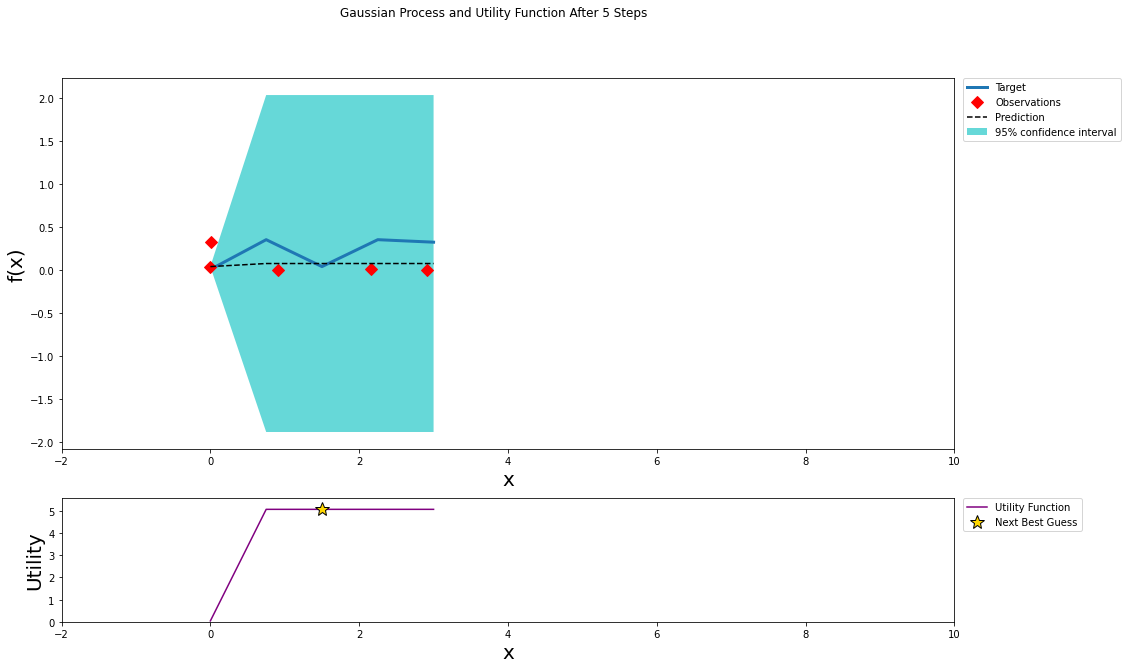

In [ ]:
x = np.linspace(0, 3, 5).reshape(-1, 1)
y = np.array([0.002659, 3.491e-1, 0.03597,  3.491e-1, 0.3199])
plot_gp(optimizer, x, y)


# Predict

In [ ]:
import os
test_dataset = BasicDataset(test_dir_img, test_dir_mask, 1.)
predict_dataloader = DataLoader(test_dataset, shuffle=False, batch_size = 1)
os.mkdir("./predicts")
def mask_to_image(mask: np.ndarray):
    if mask.ndim == 2:
        return Image.fromarray((mask * 255).astype(np.uint8))
    elif mask.ndim == 3:
        return Image.fromarray((np.argmax(mask, axis=0) * 255 / mask.shape[0]).astype(np.uint8))


for idx, batch in enumerate(predict_dataloader):
    model.eval()
    out = model(batch["image"].to(device))
    if model.n_classes > 1:
        probs = F.softmax(out, dim=1)[0]
    else:
        probs = torch.sigmoid(output)[0]
    probs = probs[:,:584,:] # 1 for padding (drive)
    
    tf = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor()
        ])
    
    full_mask = tf(probs.cpu()).squeeze()

    if model.n_classes == 1:
        predicted = (full_mask > 0.5).numpy()
    else:
        predicted = F.one_hot(full_mask.argmax(dim=0), model.n_classes).permute(2, 0, 1).numpy()
    result = mask_to_image(predicted)
    filename = batch["filename"][-1]
    result.save(f"predicts/{filename}")

In [ ]:
from google.colab import files
!zip -r -q /content/predicts.zip /content/predicts

files.download("/content/predicts.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
rm -rf predicts